This Model have 3 main parts:
1. EDA to identify and exclude:
1.1. Multivariate outlier rows.
1.2. Features with different patterns among train and test set.
2. Dimensional reduction using PLS Regression.
3. Deep Learning modeling full based on "MoA | Pytorch | 0.01859 | RankGauss | PCA | NN" developed by Kushal Agrawal ( @kushal1506 ) ( https://www.kaggle.com/kushal1506 )


In [1]:
# <> | 
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import os
import gc
import random
import math
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss

import category_encoders as ce

In [4]:
train_features=pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets_scored=pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
test_features=pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
sample_submission=pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
train_targets_nonscored=pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')

In [5]:
# Copy of original data

train_f = train_features
train_t = train_targets_scored
test_f = test_features


In [6]:
## Concatenate categorical features in train_f 
train_f["CatGral"]=train_f["cp_type"]+"_"+train_f["cp_time"].astype(str)+"_"+train_f["cp_dose"]
train_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,CatGral
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,trt_cp_24_D1
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,trt_cp_72_D1
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,trt_cp_48_D1
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,trt_cp_48_D1
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,trt_cp_72_D2


In [7]:
# Concatenate categorical features in test_f
test_f["CatGral"]=test_f["cp_type"]+"_"+test_f["cp_time"].astype(str)+"_"+test_f["cp_dose"]
test_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,CatGral
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750,trt_cp_24_D1
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300,trt_cp_72_D1
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942,ctl_vehicle_24_D1
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809,trt_cp_24_D2
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380,trt_cp_48_D1


In [8]:
# OHE to categorical features in train_f

train_f2 = pd.get_dummies(train_f["cp_type"])
train_f3 = pd.get_dummies(train_f["cp_time"])
train_f4 = pd.get_dummies(train_f["cp_dose"])
train_f5 = pd.get_dummies(train_f["CatGral"])
train_f = pd.concat([train_f, train_f2, train_f3, train_f4, train_f5], axis=1)
train_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ctl_vehicle_48_D1,ctl_vehicle_48_D2,ctl_vehicle_72_D1,ctl_vehicle_72_D2,trt_cp_24_D1,trt_cp_24_D2,trt_cp_48_D1,trt_cp_48_D2,trt_cp_72_D1,trt_cp_72_D2
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,1,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,1,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,1,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,1,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# OHE to categorical features in test_f

test_f2 = pd.get_dummies(test_f["cp_type"])
test_f3 = pd.get_dummies(test_f["cp_time"])
test_f4 = pd.get_dummies(test_f["cp_dose"])
test_f5 = pd.get_dummies(test_f["CatGral"])
test_f = pd.concat([test_f, test_f2, test_f3, test_f4, test_f5], axis=1)
test_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ctl_vehicle_48_D1,ctl_vehicle_48_D2,ctl_vehicle_72_D1,ctl_vehicle_72_D2,trt_cp_24_D1,trt_cp_24_D2,trt_cp_48_D1,trt_cp_48_D2,trt_cp_72_D1,trt_cp_72_D2
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0,0,0,0,1,0,0,0,0,0
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0,0,0,0,0,0,0,0,1,0
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0,0,0,0,0,0,0,0,0,0
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0,0,0,0,0,1,0,0,0,0
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0,0,0,0,0,0,1,0,0,0


In [10]:
# Count Encoding (CE) to categorical features in train_f
import category_encoders as ce
cat_features = ["cp_type", "cp_time", "cp_dose", "CatGral"]
count_enc = ce.CountEncoder(cols = cat_features)
count_enc.fit(train_f[cat_features])
train_f = train_f.join(count_enc.transform(train_f[cat_features]).add_suffix("_2"))

train_f

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,trt_cp_24_D1,trt_cp_24_D2,trt_cp_48_D1,trt_cp_48_D2,trt_cp_72_D1,trt_cp_72_D2,cp_type_2,cp_time_2,cp_dose_2,CatGral_2
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,1,0,0,0,0,0,21948,7772,12147,3585
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,1,0,21948,7792,12147,3600
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,1,0,0,0,21948,8250,12147,4011
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,1,0,0,0,21948,8250,12147,4011
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,1,21948,7792,11667,3580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0,1,0,0,0,0,21948,7772,11667,3581
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0,1,0,0,0,0,21948,7772,11667,3581
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0,0,0,0,0,0,1866,8250,11667,305
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,1,0,0,0,0,0,21948,7772,12147,3585


In [11]:
# Count Encoding (CE) to categorical features in test_f
import category_encoders as ce
cat_features = ["cp_type", "cp_time", "cp_dose", "CatGral"]
count_enc = ce.CountEncoder(cols = cat_features)
count_enc.fit(test_f[cat_features])
test_f = test_f.join(count_enc.transform(test_f[cat_features]).add_suffix("_2"))

test_f

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,trt_cp_24_D1,trt_cp_24_D2,trt_cp_48_D1,trt_cp_48_D2,trt_cp_72_D1,trt_cp_72_D2,cp_type_2,cp_time_2,cp_dose_2,CatGral_2
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,1,0,0,0,0,0,3624,1300,2027,590
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0,0,0,0,1,0,3624,1305,2027,595
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0,0,0,0,0,0,358,1300,2027,58
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0,1,0,0,0,0,3624,1300,1955,594
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0,0,1,0,0,0,3624,1377,2027,660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,1,0,0,0,0,0,3624,1300,2027,590
3978,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,1,0,0,0,0,0,3624,1300,2027,590
3979,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0,0,0,0,1,0,3624,1305,2027,595
3980,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,0,0,0,1,0,0,3624,1377,1955,593


In [12]:
# EDA 01: 1. join train and test features in a global data 
train_f["source"] = "train"
test_f["source"] = "test"
data = pd.concat([train_f, test_f], axis=0)
data.reset_index(inplace = True, drop = False)
data.rename(columns={'index': 'index_old'}, inplace=True)
data


,index_old,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,...,trt_cp_24_D2,trt_cp_48_D1,trt_cp_48_D2,trt_cp_72_D1,trt_cp_72_D2,cp_type_2,cp_time_2,cp_dose_2,CatGral_2,source
0,0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0,0,0,0,0,21948,7772,12147,3585,train
1,1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,...,0,0,0,1,0,21948,7792,12147,3600,train
2,2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,0,1,0,0,0,21948,8250,12147,4011,train
3,3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,0,1,0,0,0,21948,8250,12147,4011,train
4,4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0,0,0,0,1,21948,7792,11667,3580,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,3977,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,...,0,0,0,0,0,3624,1300,2027,590,test
27792,3978,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,...,0,0,0,0,0,3624,1300,2027,590,test
27793,3979,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,...,0,0,0,1,0,3624,1305,2027,595,test
27794,3980,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,...,0,0,1,0,0,3624,1377,1955,593,test


In [13]:
cols = data.iloc[:,5:877].columns
cols
# data.iloc[:,-1][23810:23820]

Index(['g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'g-5', 'g-6', 'g-7', 'g-8', 'g-9',
       ...
       'c-90', 'c-91', 'c-92', 'c-93', 'c-94', 'c-95', 'c-96', 'c-97', 'c-98',
       'c-99'],
      dtype='object', length=872)

In [14]:
cols2 = pd.DataFrame(cols, columns = ["name1"])
cols2["name2"] = cols2["name1"]+"_std"
cols3 = cols2["name2"].values.tolist()
print(cols3[0:5])
print("...")
print(cols3[870:880])


['g-0_std', 'g-1_std', 'g-2_std', 'g-3_std', 'g-4_std']
...
['c-98_std', 'c-99_std']


In [15]:
# To standard consolidated DF "data"
import sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
SCALE = StandardScaler()
SCALE.fit(data[cols])
data_scale = SCALE.transform(data[cols])



data_scale2 = pd.DataFrame(data_scale, columns = cols3)
data = pd.concat([data, data_scale2], axis=1)
data.head()



,index_old,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,...,c-90_std,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std
0,0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.374483,0.350185,0.658979,0.496197,0.144522,0.619692,0.028937,0.343735,0.459887,0.510189
1,1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,...,0.018538,0.593774,0.490262,0.245361,0.370135,0.516419,0.295606,0.290815,0.584348,0.738308
2,2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.130542,-0.086056,0.560143,0.245029,-0.380379,0.021625,-0.089108,0.088798,-0.517924,0.706892
3,3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-0.816759,-0.093130,-2.565871,-0.418574,-0.166860,-0.573255,-0.563665,-0.299973,0.040075,-0.370158
4,4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.233643,0.225615,0.588546,0.741062,0.489035,0.030390,0.274865,0.387698,0.044996,0.720744


In [16]:
# To standard  DF "train_f"

# import sklearn.preprocessing 
# from sklearn.preprocessing import StandardScaler
SCALE = StandardScaler()
SCALE.fit(train_f[cols])
train_f_scale = SCALE.transform(train_f[cols])

train_f_scale2 = pd.DataFrame(train_f_scale, columns = cols3)
train_f = pd.concat([train_f, train_f_scale2], axis=1)
train_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90_std,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.377638,0.352428,0.659876,0.499484,0.146278,0.621219,0.031745,0.347587,0.463460,0.510769
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.021367,0.595227,0.491617,0.248281,0.371742,0.517798,0.298922,0.294874,0.587507,0.737704
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.127850,-0.082397,0.561309,0.247948,-0.378278,0.022296,-0.086525,0.093651,-0.511093,0.706452
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.814697,-0.089447,-2.556236,-0.416627,-0.164899,-0.573436,-0.561987,-0.293593,0.045047,-0.365011
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.236669,0.228262,0.589635,0.744707,0.490563,0.031073,0.278143,0.391377,0.049952,0.720231


In [17]:
# To standard  DF "test_f"

# import sklearn.preprocessing 
# from sklearn.preprocessing import StandardScaler
SCALE = StandardScaler()
SCALE.fit(test_f[cols])
test_f_scale = SCALE.transform(test_f[cols])

test_f_scale2 = pd.DataFrame(test_f_scale, columns = cols3)
test_f = pd.concat([test_f, test_f_scale2], axis=1)
test_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90_std,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.262349,0.606970,0.169501,0.120187,0.115796,0.138047,0.213217,0.160807,0.310422,-0.372637
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0.154494,0.114283,-0.282824,-0.425013,0.051267,-0.116532,0.220357,-0.096666,-0.545130,-0.339445
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0.101287,0.376014,-0.462633,0.621595,-0.685671,-0.405691,0.618271,0.804914,0.501078,0.055756
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.276210,0.285796,0.151469,-0.308953,0.021725,-0.336714,0.592823,0.112297,0.541342,-0.229471
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.460274,0.586922,0.161860,0.711154,0.490080,0.872977,0.061202,-0.129832,0.780696,1.554687


In [18]:
cols4 = train_f.iloc[:,901:1773].columns
cols4

Index(['g-0_std', 'g-1_std', 'g-2_std', 'g-3_std', 'g-4_std', 'g-5_std',
       'g-6_std', 'g-7_std', 'g-8_std', 'g-9_std',
       ...
       'c-90_std', 'c-91_std', 'c-92_std', 'c-93_std', 'c-94_std', 'c-95_std',
       'c-96_std', 'c-97_std', 'c-98_std', 'c-99_std'],
      dtype='object', length=872)

In [19]:
# Detection of multivariate outliers in train_f
# Module of standardized features

# cols = train_f.iloc[:,901:1772].columns
train_ft = train_f[cols4].T
tot = np.sqrt(np.square(train_ft).sum())
totdf = pd.DataFrame(tot, columns = ["norm"])
train_f = pd.concat([train_f, totdf], axis=1)
# train_f.rename(columns={0: 'norm'}, inplace=True)
train_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.352428,0.659876,0.499484,0.146278,0.621219,0.031745,0.347587,0.463460,0.510769,20.033820
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.595227,0.491617,0.248281,0.371742,0.517798,0.298922,0.294874,0.587507,0.737704,20.308562
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.082397,0.561309,0.247948,-0.378278,0.022296,-0.086525,0.093651,-0.511093,0.706452,23.623215
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.089447,-2.556236,-0.416627,-0.164899,-0.573436,-0.561987,-0.293593,0.045047,-0.365011,28.047351
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.228262,0.589635,0.744707,0.490563,0.031073,0.278143,0.391377,0.049952,0.720231,25.160934


In [20]:
# Detection of multivariate outliers in test_f
# Module of standardized features

# cols = test_f.iloc[:,901:1772].columns
test_ft = test_f[cols4].T
tot = np.sqrt(np.square(test_ft).sum())
totdf = pd.DataFrame(tot, columns = ["norm"])
test_f = pd.concat([test_f, totdf], axis=1)
test_f.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.606970,0.169501,0.120187,0.115796,0.138047,0.213217,0.160807,0.310422,-0.372637,17.660285
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0.114283,-0.282824,-0.425013,0.051267,-0.116532,0.220357,-0.096666,-0.545130,-0.339445,20.655737
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0.376014,-0.462633,0.621595,-0.685671,-0.405691,0.618271,0.804914,0.501078,0.055756,20.307135
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.285796,0.151469,-0.308953,0.021725,-0.336714,0.592823,0.112297,0.541342,-0.229471,19.238566
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.586922,0.161860,0.711154,0.490080,0.872977,0.061202,-0.129832,0.780696,1.554687,18.908564


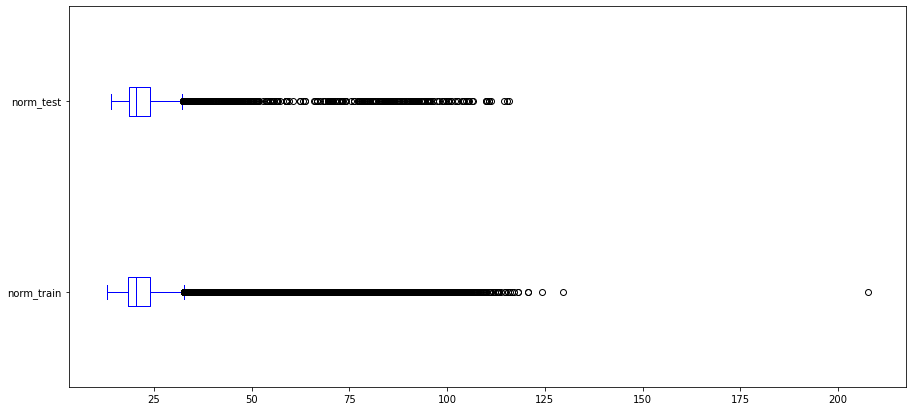

In [21]:
bxplt_norm = pd.concat([train_f["norm"], test_f["norm"]], axis = 1)
bxplt_norm.columns = ["norm_train", "norm_test"]
bxplt_norm.plot(kind = "box", figsize = (15, 7), color = "blue", vert = False)

# test_f["norm"].plot(kind = "box", figsize = (10, 7), color = "blue", vert = False)

In [22]:
# <>|
# Identifying the outlier:

# train_f.loc[train_f.loc[:,"norm"]> 150]

In [23]:
# Module of standardized features on data:

DCols = data.iloc[:,902:1774].columns
datat = data[DCols].T
tot = np.sqrt(np.square(datat).sum())
totdf = pd.DataFrame(tot, columns = ["norm"])
data = pd.concat([data, totdf], axis=1)
data.head()

,index_old,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,...,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm
0,0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.350185,0.658979,0.496197,0.144522,0.619692,0.028937,0.343735,0.459887,0.510189,20.045971
1,1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,...,0.593774,0.490262,0.245361,0.370135,0.516419,0.295606,0.290815,0.584348,0.738308,20.321696
2,2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.086056,0.560143,0.245029,-0.380379,0.021625,-0.089108,0.088798,-0.517924,0.706892,23.655027
3,3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-0.093130,-2.565871,-0.418574,-0.166860,-0.573255,-0.563665,-0.299973,0.040075,-0.370158,28.144832
4,4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.225615,0.588546,0.741062,0.489035,0.030390,0.274865,0.387698,0.044996,0.720744,25.187069


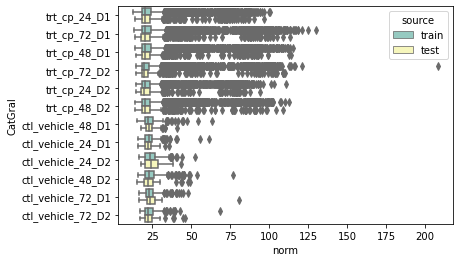

In [24]:
# Distribution of modules per category and source:
df_dist = data[["CatGral", "source", "norm"]]
ax = sns.boxplot(x="norm", y="CatGral", hue="source",
                 data=df_dist, palette="Set3")

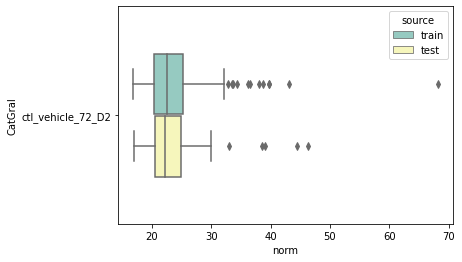

In [25]:
# Visualize outliers_2 graphicallly:
# Z[Z.genre == sex]
df_dist2 = df_dist[df_dist.CatGral == "ctl_vehicle_72_D2"]
ax = sns.boxplot(x="norm", y="CatGral", hue="source",
                 data=df_dist2, palette="Set3")

In [26]:
# Identify  outliers_2:

sub_data_b = data[data.source == "train"]
sub_data = sub_data_b[sub_data_b.CatGral == "ctl_vehicle_72_D2"]
sub_data[sub_data.norm > 60].loc[:,["sig_id", "norm"]].sort_values(by = "norm", ascending = False)

,sig_id,norm
3845,id_2926afaf1,68.154634


In [27]:
# Identify  outliers:
# train_f

# categories = np.unique(train_f["CatGral"], return_index=False, return_inverse=False, return_counts=False, axis=None)

# for cat in X2.CatGral.unique():
#     X3 = X2[X2.CatGral == cat].drop(["CatGral"], axis = 1)

outliers_train_id = []

for cat in train_f.CatGral.unique():
    X4 = train_f[train_f.CatGral == cat]
    Q1 = X4.loc[:,"norm"].describe()[4]
    Q3 = X4.loc[:,"norm"].describe()[6]
    ls = Q3 + (1.5*(Q3 - Q1))
    for i in range(0,len(X4)):
        if (X4.norm.iloc[i] > ls):
            outliers_train_id.append(X4.sig_id.iloc[i])
outliers_train_id[0:5]

['id_0079d45d3',
 'id_009379beb',
 'id_00fb2c241',
 'id_02088f9bb',
 'id_022ab81bd']

In [28]:
# Identify  outliers:
# test_f

outliers_test_id = []

for cat in test_f.CatGral.unique():
    X4 = test_f[test_f.CatGral == cat]
    Q1 = X4.loc[:,"norm"].describe()[4]
    Q3 = X4.loc[:,"norm"].describe()[6]
    ls = Q3 + (1.5*(Q3 - Q1))
    for i in range(0,len(X4)):
        if (X4.norm.iloc[i] > ls):
            outliers_test_id.append(X4.sig_id.iloc[i])
outliers_test_id[0:5]

['id_02072e865',
 'id_056059794',
 'id_1175b14a5',
 'id_1562a18d7',
 'id_176fcfb63']

In [29]:
# Create columns to identify outliers:

train_f["outliers1"] = train_f["sig_id"].isin(outliers_train_id).astype(int)
test_f["outliers1"] = test_f["sig_id"].isin(outliers_test_id).astype(int)
print("train_f: ", train_f.shape, "test_f: ", test_f.shape)

train_f:  (23814, 1775) test_f:  (3982, 1775)


In [30]:
# Create columns to identify outliers:

outliers2_id = train_f.iloc[[5773, 15209, 11701, 22971, 16234, 10853, 16674, 10738, 15161, 12139, 16218, 11088, 20005, 
                             11788, 2729, 15195, 2570, 16241, 19845, 17431, 3845]].sig_id
# outliers2_id
train_f["outliers2"] = train_f["sig_id"].isin(outliers2_id).astype(int)
test_f["outliers2"] = 0 # train_f["sig_id"].isin(outliers2_id).astype(int)
print("train_f: ", train_f.shape, "test_f: ", test_f.shape)


train_f:  (23814, 1776) test_f:  (3982, 1776)


In [31]:
# Stratify outliers in different groups:
# Categorical groups:

# Z.drop(["countri2","category"], axis = 1, inplace = True)

train_f["CatGral3"] = train_f["CatGral"]+"_"+train_f["outliers1"].astype(str)
test_f["CatGral3"] = test_f["CatGral"]+"_"+test_f["outliers1"].astype(str)
print("train_f: ", train_f.shape, "test_f: ", test_f.shape)

# train_f

train_f:  (23814, 1777) test_f:  (3982, 1777)


In [32]:
train_f.loc[train_f.loc[:,"outliers1"]==1, "CatGral3"] = "outlier"
test_f.loc[test_f.loc[:,"outliers1"]==1, "CatGral3"] = "outlier"
test_f

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm,outliers1,outliers2,CatGral3
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.115796,0.138047,0.213217,0.160807,0.310422,-0.372637,17.660285,0,0,trt_cp_24_D1_0
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0.051267,-0.116532,0.220357,-0.096666,-0.545130,-0.339445,20.655737,0,0,trt_cp_72_D1_0
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.685671,-0.405691,0.618271,0.804914,0.501078,0.055756,20.307135,0,0,ctl_vehicle_24_D1_0
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.021725,-0.336714,0.592823,0.112297,0.541342,-0.229471,19.238566,0,0,trt_cp_24_D2_0
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.490080,0.872977,0.061202,-0.129832,0.780696,1.554687,18.908564,0,0,trt_cp_48_D1_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.081279,-0.080615,-0.404525,-0.490307,-0.006613,-0.287814,16.925375,0,0,trt_cp_24_D1_0
3978,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.656170,0.984192,0.328426,0.022586,0.218779,0.130105,16.425889,0,0,trt_cp_24_D1_0
3979,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.668081,0.494117,0.225246,0.546836,-0.008735,0.088062,18.324234,0,0,trt_cp_72_D1_0
3980,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,0.368700,0.288703,0.077687,0.497662,0.641026,0.163296,23.051535,0,0,trt_cp_48_D2_0


In [33]:
# Stratify outliers in different groups:
# Numerical group categories:

# Count Encoding (CE) to categorical features in test_f
# import category_encoders as ce
# cat_features = ["cp_type", "cp_time", "cp_dose", "CatGral"]
count_enc = ce.CountEncoder(cols = ["CatGral3"])
count_enc.fit(train_f["CatGral3"])
train_f = train_f.join(count_enc.transform(train_f["CatGral3"]).add_suffix("_num"))

# count_enc = ce.CountEncoder(cols = ["CatGral3"])
count_enc.fit(test_f["CatGral3"])
test_f = test_f.join(count_enc.transform(test_f["CatGral3"]).add_suffix("_num"))
print("train_f: ", train_f.shape, "test_f: ", test_f.shape)

train_f:  (23814, 1778) test_f:  (3982, 1778)


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [34]:
# Centroids of general (train and test) standardized features:

cols_data_st = data.iloc[:,901:1774].columns
group_means = data[cols_data_st].groupby(["source"], as_index = False).mean()
group_means

,source,g-0_std,g-1_std,g-2_std,g-3_std,g-4_std,g-5_std,g-6_std,g-7_std,g-8_std,...,c-90_std,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std
0,test,-0.031356,0.034292,-0.012138,-0.029172,-0.004100,-0.006530,-0.024886,0.027352,0.010851,...,0.016800,0.020282,0.016091,0.015290,0.011075,0.003820,0.016432,0.031230,0.030637,0.019399
1,train,0.005243,-0.005734,0.002030,0.004878,0.000686,0.001092,0.004161,-0.004574,-0.001814,...,-0.002809,-0.003391,-0.002691,-0.002557,-0.001852,-0.000639,-0.002748,-0.005222,-0.005123,-0.003244


In [35]:
# group_means.iloc[:,875:880]
# data.head()
cols_group = group_means.iloc[:,1:873].columns
cols_group

Index(['g-0_std', 'g-1_std', 'g-2_std', 'g-3_std', 'g-4_std', 'g-5_std',
       'g-6_std', 'g-7_std', 'g-8_std', 'g-9_std',
       ...
       'c-90_std', 'c-91_std', 'c-92_std', 'c-93_std', 'c-94_std', 'c-95_std',
       'c-96_std', 'c-97_std', 'c-98_std', 'c-99_std'],
      dtype='object', length=872)

In [36]:
# cols = group_means.iloc[:,1:876].columns
group_meanst = group_means[cols_group].T
tot = np.sqrt(np.square(group_meanst).sum())
totdf = pd.DataFrame(tot, columns = ["norm"])
group_means = pd.concat([group_means, totdf], axis=1)
group_means.head()

,source,g-0_std,g-1_std,g-2_std,g-3_std,g-4_std,g-5_std,g-6_std,g-7_std,g-8_std,...,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm
0,test,-0.031356,0.034292,-0.012138,-0.029172,-0.004100,-0.006530,-0.024886,0.027352,0.010851,...,0.020282,0.016091,0.015290,0.011075,0.003820,0.016432,0.031230,0.030637,0.019399,0.584863
1,train,0.005243,-0.005734,0.002030,0.004878,0.000686,0.001092,0.004161,-0.004574,-0.001814,...,-0.003391,-0.002691,-0.002557,-0.001852,-0.000639,-0.002748,-0.005222,-0.005123,-0.003244,0.097796


In [37]:
# cols = group_means.iloc[:,1:876].columns
group_meanst = group_means[cols_group].T
tot = np.sqrt(np.square(group_meanst).mean())
totdf = pd.DataFrame(tot, columns = ["mean"])
group_means = pd.concat([group_means, totdf], axis=1)
group_means.head()

,source,g-0_std,g-1_std,g-2_std,g-3_std,g-4_std,g-5_std,g-6_std,g-7_std,g-8_std,...,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm,mean
0,test,-0.031356,0.034292,-0.012138,-0.029172,-0.004100,-0.006530,-0.024886,0.027352,0.010851,...,0.016091,0.015290,0.011075,0.003820,0.016432,0.031230,0.030637,0.019399,0.584863,0.019806
1,train,0.005243,-0.005734,0.002030,0.004878,0.000686,0.001092,0.004161,-0.004574,-0.001814,...,-0.002691,-0.002557,-0.001852,-0.000639,-0.002748,-0.005222,-0.005123,-0.003244,0.097796,0.003312


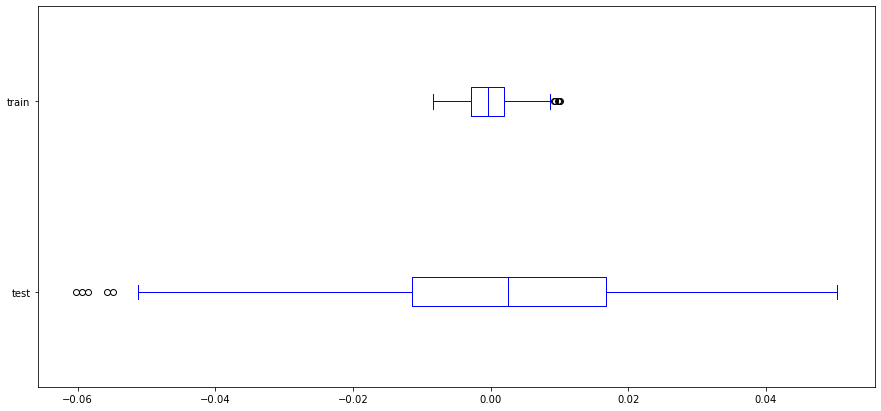

In [38]:
# cols = group_means.iloc[:,1:876].columns
group_meanst2 = group_meanst
group_meanst2.rename(columns={0: 'test', 1: 'train'}, inplace=True)
group_meanst2.plot(kind = "box", figsize = (15, 7), color = "blue", vert = False)

In [39]:
desc = group_meanst2.describe()
desc

,test,train
count,872.000000,872.000000
mean,0.002193,-0.000367
std,0.019695,0.003293
min,-0.060295,-0.008403
25%,-0.011487,-0.002802
50%,0.002504,-0.000419
75%,0.016758,0.001921
max,0.050254,0.010082


In [40]:
desc.loc["50%","train"] - desc.loc["25%","train"]

0.0023834261216901503

In [41]:
li = desc.loc["25%","test"] - 3*(desc.loc["50%","test"] - desc.loc["25%","test"])
# li

# <>|
group_meanst2.loc[group_meanst2.loc[:,"test"]< li]

,test,train
g-22_std,-0.058530,0.009787
g-101_std,-0.060295,0.010082
g-135_std,-0.059298,0.009915
g-392_std,-0.055696,0.009313
g-656_std,-0.054901,0.009180


In [42]:
# Defining predictor features:

col_sorted2 = ['sig_id', 'CatGral3','CatGral3_num','CatGral_2','ctl_vehicle', 'trt_cp', 24, 48, 72, 'D1', 'D2', 'ctl_vehicle_24_D1',
                'ctl_vehicle_24_D2', 'ctl_vehicle_48_D1', 'ctl_vehicle_48_D2', 'ctl_vehicle_72_D1', 'ctl_vehicle_72_D2', 'trt_cp_24_D1',
                'trt_cp_24_D2', 'trt_cp_48_D1', 'trt_cp_48_D2', 'trt_cp_72_D1', 'trt_cp_72_D2', 'cp_type_2', 'cp_time_2',
                'cp_dose_2', *train_f.iloc[:,4:1774].columns]
col_sorted = col_sorted2[:] # [898:923]

# Deleting repeated categorical columns:
del col_sorted[898:923] 
# col_sorted

In [43]:
# col_qt_f = train_f.iloc[:,4:901].columns
# col_qt
train_f_qt = train_f[col_sorted]
test_f_qt = test_f[col_sorted]
# print("train_f_qt: ", train_f_qt.shape, "test_f_qt: ", test_f_qt.shape)
print("train_f_qt: ", train_f_qt.shape)
print(train_f_qt.iloc[0:5,[0,1,2,1769,1770]])
print("test_f_qt: ", test_f_qt.shape)
print(test_f_qt.iloc[0:5,[0,1,2,1769,1770]])

train_f_qt:  (23814, 1771)
         sig_id        CatGral3  CatGral3_num  c-99_std       norm
0  id_000644bb2  trt_cp_24_D1_0          3173  0.510769  20.033820
1  id_000779bfc  trt_cp_72_D1_0          3081  0.737704  20.308562
2  id_000a6266a  trt_cp_48_D1_0          3480  0.706452  23.623215
3  id_0015fd391  trt_cp_48_D1_0          3480 -0.365011  28.047351
4  id_001626bd3  trt_cp_72_D2_0          3078  0.720231  25.160934
test_f_qt:  (3982, 1771)
         sig_id             CatGral3  CatGral3_num  c-99_std       norm
0  id_0004d9e33       trt_cp_24_D1_0           522 -0.372637  17.660285
1  id_001897cda       trt_cp_72_D1_0           513 -0.339445  20.655737
2  id_002429b5b  ctl_vehicle_24_D1_0            56  0.055756  20.307135
3  id_00276f245       trt_cp_24_D2_0           531 -0.229471  19.238566
4  id_0027f1083       trt_cp_48_D1_0           567  1.554687  18.908564


In [44]:
# ZZ BORRAR ???
# train_f_qt.iloc[:,1765:1780]
# col_qt_t = train_t.iloc[:,1770:1780].columns
# col_qt_t
# train_t_qt = train_t[col_qt_t]
# train_t_qt

In [45]:
# outliers2_id = train_f.iloc[[5773, 15209, 11701, 22971, 16234, 10853, 16674, 10738, 15161, 12139, 16218, 11088, 20005, 
#                              11788, 2729, 15195, 2570, 16241, 19845, 17431, 3845]].sig_id

train_f_qt_b = train_f_qt.drop([5773, 15209, 11701, 22971, 16234, 10853, 16674, 10738, 15161, 12139, 16218, 11088, 20005, 
                             11788, 2729, 15195, 2570, 16241, 19845, 17431, 3845], axis=0)
train_t_qt_b = train_t.drop([5773, 15209, 11701, 22971, 16234, 10853, 16674, 10738, 15161, 12139, 16218, 11088, 20005, 
                             11788, 2729, 15195, 2570, 16241, 19845, 17431, 3845], axis=0)


In [46]:
train_f_qt_c = train_f_qt_b.drop(["g-22", "g-101", "g-135", "g-392", "g-656"], axis=1)
test_f_qt_c = test_f_qt.drop(["g-22", "g-101", "g-135", "g-392", "g-656"], axis=1)
print("train_f_qt_c: ", train_f_qt_c.shape, "test_f_qt_c: ", test_f_qt_c.shape)

# train_f_qt_c.iloc[:,890:]

train_f_qt_c:  (23793, 1766) test_f_qt_c:  (3982, 1766)


In [47]:
# train_f_qt_c
# train_t_qt_b
data2 = pd.merge(train_f_qt_c, train_t_qt_b, on='sig_id', how='left')
data2 = data2.sort_values("CatGral3")
data2

,sig_id,CatGral3,CatGral3_num,CatGral_2,ctl_vehicle,trt_cp,24,48,72,D1,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
21894,id_eb04c174f,ctl_vehicle_24_D1_0,287,301,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10968,id_761e5ab26,ctl_vehicle_24_D1_0,287,301,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18981,id_cbe6fb60b,ctl_vehicle_24_D1_0,287,301,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18979,id_cbe1576a9,ctl_vehicle_24_D1_0,287,301,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10952,id_75f3a7e55,ctl_vehicle_24_D1_0,287,301,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14476,id_9beb36198,trt_cp_72_D2_0,3078,3580,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3767,id_284779465,trt_cp_72_D2_0,3078,3580,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3768,id_284f29fea,trt_cp_72_D2_0,3078,3580,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8625,id_5cf06d06f,trt_cp_72_D2_0,3078,3580,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# train_f_qt_c
# train_t_qt_b
# data2.iloc[:,20:30] #890:900]
# zzx = data2.iloc[:,1969:1980] # .drop(data2.loc[:,["CatGral", "source"]]
# zzx
# zzx

In [49]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# Note: In X2 was dropped categorical column CatGral (column 893)
X2 = data2.iloc[:,0:1766] # .drop(data2.loc[:,"CatGral"], axis =1)
y2 = data2.drop(data2.iloc[:,2:1766], axis =1) # train_t_qt_2_b
# # scores = []
# # xscores = pd.DataFrame()
# # n_subsets = []
# # predictions = []
W = []

for cat in X2.CatGral3.unique():
    X3 = X2[X2.CatGral3 == cat].drop(["sig_id", "CatGral3"], axis = 1)
    y3 = y2[y2.CatGral3 == cat].drop(["sig_id", "CatGral3"], axis = 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    pls_05 = PLSRegression(n_components = 204, max_iter = 5000)
    pls_05.fit(X3, y3)
    # # xscoresi = pd.DataFrame(pls_05.x_scores_)
    # # xscores = pd.concat([xscores, xscoresi], axis=0)
    W.append(pls_05.x_weights_)
    # xscores.append(pls_05.x_scores_)
    # log = (1/(1+(math.exp(1)**-pls_05.predict(X3)))).round(0)
    # predictions.append(log)
#     scores.append(pls_05.score(X3, y3))
#     n_subsets.append(X3.shape[0])
    

# results = pd.DataFrame({"scores": scores, "n": n_subsets })
# results["scxn"] = results["scores"]*results["n"]
# prom_results = results.sum()[2]/results.sum()[1]
# prom_results
# predictions[0]
# xscores

/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:323: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:323: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:323: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:323: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:323: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decompositio

In [50]:
W[0].shape
# len(W[0][0])

(1764, 204)

In [51]:
# List of data categories:
cat_id = X2.CatGral3.unique().tolist()
cat_id

['ctl_vehicle_24_D1_0',
 'ctl_vehicle_24_D2_0',
 'ctl_vehicle_48_D1_0',
 'ctl_vehicle_48_D2_0',
 'ctl_vehicle_72_D1_0',
 'ctl_vehicle_72_D2_0',
 'outlier',
 'trt_cp_24_D1_0',
 'trt_cp_24_D2_0',
 'trt_cp_48_D1_0',
 'trt_cp_48_D2_0',
 'trt_cp_72_D1_0',
 'trt_cp_72_D2_0']

In [52]:
cols_pls = []
for i in range(204):
    z = "T_" + str(i) #.astype(str)
    cols_pls.append(z)
cols_pls.append("sig_id")
# cols_pls

In [53]:
from pandas import DataFrame

T_train = [] # pd.DataFrame()
for i, cat in enumerate(cat_id):
    X3 = X2[X2.CatGral3 == cat]
    Tsub = np.dot(X3.drop(["sig_id", "CatGral3"], axis = 1),W[i]).tolist()
    
    for j, row in enumerate(Tsub):
        Tsub[j].append(X3["sig_id"].iloc[j])
    
    for j, row in enumerate(Tsub):
        T_train.append(Tsub[j])

T_train = DataFrame(T_train, columns = cols_pls) # ["T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "sig_id"])
# T = T[["sig_id", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"]]
train_f_qt_d = pd.merge(train_f_qt_c, T_train, on='sig_id', how='left')
train_f_qt_d

,sig_id,CatGral3,CatGral3_num,CatGral_2,ctl_vehicle,trt_cp,24,48,72,D1,...,T_194,T_195,T_196,T_197,T_198,T_199,T_200,T_201,T_202,T_203
0,id_000644bb2,trt_cp_24_D1_0,3173,3585,0,1,1,0,0,1,...,0.546029,0.102652,1.418793,0.441696,-0.848766,1.032108,0.958888,-0.287577,-0.082079,0.114895
1,id_000779bfc,trt_cp_72_D1_0,3081,3600,0,1,0,0,1,1,...,-0.497224,-0.303050,-0.547359,-1.038666,0.899809,0.073530,0.161370,-0.353960,0.536404,-0.339614
2,id_000a6266a,trt_cp_48_D1_0,3480,4011,0,1,0,1,0,1,...,-1.757769,-0.000151,0.550945,-0.555449,-1.483973,1.778854,1.431057,-2.898130,-0.294336,0.793451
3,id_0015fd391,trt_cp_48_D1_0,3480,4011,0,1,0,1,0,1,...,-2.334685,-0.958789,-2.531688,-0.278176,-0.690725,0.037322,1.536914,-1.757850,-0.802434,-1.216241
4,id_001626bd3,trt_cp_72_D2_0,3078,3580,0,1,0,0,1,0,...,2.237630,-0.628877,1.092074,-1.314835,-0.373994,-0.052592,0.573185,-0.417370,-1.500399,-0.243671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23788,id_fffb1ceed,trt_cp_24_D2_0,3192,3581,0,1,1,0,0,0,...,0.074880,1.118056,0.482436,-0.787783,-2.003888,0.798765,2.825518,-1.583667,-1.548652,-2.417292
23789,id_fffb70c0c,trt_cp_24_D2_0,3192,3581,0,1,1,0,0,0,...,-0.881367,0.017101,-0.687897,1.696709,-0.942553,1.712911,1.255208,0.555172,-1.177243,3.880932
23790,id_fffc1c3f4,ctl_vehicle_48_D2_0,282,305,1,0,0,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23791,id_fffcb9e7c,trt_cp_24_D1_0,3173,3585,0,1,1,0,0,1,...,-3.335325,-0.325050,-0.974677,-2.060799,-0.160418,-0.887721,-0.622016,-0.890430,0.378658,-1.746945


In [54]:
test_f_qt_c
# W[0].shape
# X2[X2.CatGral3 == "ctl_vehicle_24_D1_0"]

,sig_id,CatGral3,CatGral3_num,CatGral_2,ctl_vehicle,trt_cp,24,48,72,D1,...,c-91_std,c-92_std,c-93_std,c-94_std,c-95_std,c-96_std,c-97_std,c-98_std,c-99_std,norm
0,id_0004d9e33,trt_cp_24_D1_0,522,590,0,1,1,0,0,1,...,0.606970,0.169501,0.120187,0.115796,0.138047,0.213217,0.160807,0.310422,-0.372637,17.660285
1,id_001897cda,trt_cp_72_D1_0,513,595,0,1,0,0,1,1,...,0.114283,-0.282824,-0.425013,0.051267,-0.116532,0.220357,-0.096666,-0.545130,-0.339445,20.655737
2,id_002429b5b,ctl_vehicle_24_D1_0,56,58,1,0,1,0,0,1,...,0.376014,-0.462633,0.621595,-0.685671,-0.405691,0.618271,0.804914,0.501078,0.055756,20.307135
3,id_00276f245,trt_cp_24_D2_0,531,594,0,1,1,0,0,0,...,0.285796,0.151469,-0.308953,0.021725,-0.336714,0.592823,0.112297,0.541342,-0.229471,19.238566
4,id_0027f1083,trt_cp_48_D1_0,567,660,0,1,0,1,0,1,...,0.586922,0.161860,0.711154,0.490080,0.872977,0.061202,-0.129832,0.780696,1.554687,18.908564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp_24_D1_0,522,590,0,1,1,0,0,1,...,-0.114769,0.019897,0.224782,-0.081279,-0.080615,-0.404525,-0.490307,-0.006613,-0.287814,16.925375
3978,id_ff925dd0d,trt_cp_24_D1_0,522,590,0,1,1,0,0,1,...,0.496804,-0.057578,0.595892,0.656170,0.984192,0.328426,0.022586,0.218779,0.130105,16.425889
3979,id_ffb710450,trt_cp_72_D1_0,513,595,0,1,0,0,1,1,...,0.665862,0.147496,0.407565,0.668081,0.494117,0.225246,0.546836,-0.008735,0.088062,18.324234
3980,id_ffbb869f2,trt_cp_48_D2_0,516,593,0,1,0,1,0,0,...,-0.017083,-0.174938,0.583112,0.368700,0.288703,0.077687,0.497662,0.641026,0.163296,23.051535


In [55]:
# from pandas import DataFrame

# X2 = data2.iloc[:,0:1766] # .drop(data2.loc[:,"CatGral"], axis =1)
# y2 = data2.drop(data2.iloc[:,2:1766], axis =1) # train_t_qt_2_b

X2 = test_f_qt_c #.drop(data2.loc[:,["CatGral", "source"]], axis =1)
T_test = [] # pd.DataFrame()

for i, cat in enumerate(cat_id):
    X3 = X2[X2.CatGral3 == cat]
    Tsub = np.dot(X3.drop(["sig_id", "CatGral3"], axis = 1),W[i]).tolist()
    
    for j, row in enumerate(Tsub):
        Tsub[j].append(X3["sig_id"].iloc[j])
    
    for j, row in enumerate(Tsub):
        T_test.append(Tsub[j])

T_test = DataFrame(T_test, columns = cols_pls) # ["T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "sig_id"])
# T = T[["sig_id", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"]]
test_f_qt_d = pd.merge(test_f_qt_c, T_test, on='sig_id', how='left')
# T_test
test_f_qt_d

,sig_id,CatGral3,CatGral3_num,CatGral_2,ctl_vehicle,trt_cp,24,48,72,D1,...,T_194,T_195,T_196,T_197,T_198,T_199,T_200,T_201,T_202,T_203
0,id_0004d9e33,trt_cp_24_D1_0,522,590,0,1,1,0,0,1,...,-0.958193,-0.094130,-0.775236,0.864085,1.165991,1.103527,-0.223155,-0.252276,-1.411146,-0.400108
1,id_001897cda,trt_cp_72_D1_0,513,595,0,1,0,0,1,1,...,-1.734622,1.009446,-1.042759,-2.173407,-1.425333,0.962889,0.184664,-1.517603,0.190321,0.001262
2,id_002429b5b,ctl_vehicle_24_D1_0,56,58,1,0,1,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,trt_cp_24_D2_0,531,594,0,1,1,0,0,0,...,1.250772,-0.754720,-2.267106,-1.040271,-0.083649,-1.697735,-0.613316,0.654022,-0.644852,-0.316199
4,id_0027f1083,trt_cp_48_D1_0,567,660,0,1,0,1,0,1,...,-1.353231,-1.499938,-1.607652,-0.089940,-1.785529,-0.365658,-1.223448,-0.902518,0.387972,1.752074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp_24_D1_0,522,590,0,1,1,0,0,1,...,0.951920,-1.039302,-0.168839,-0.619868,0.951015,-1.469207,-0.015983,-1.544633,0.066909,-0.441050
3978,id_ff925dd0d,trt_cp_24_D1_0,522,590,0,1,1,0,0,1,...,0.737137,0.223383,0.325458,-1.346790,0.478596,1.767083,0.229544,0.408577,0.933928,-0.145977
3979,id_ffb710450,trt_cp_72_D1_0,513,595,0,1,0,0,1,1,...,-0.100888,-0.458524,-1.465231,-1.097608,1.664967,-1.030090,1.333470,-1.055657,0.240856,1.125164
3980,id_ffbb869f2,trt_cp_48_D2_0,516,593,0,1,0,1,0,0,...,-2.561760,-0.077112,-0.661347,1.041504,-0.605999,0.509442,0.622787,-0.490990,2.276985,0.826403


In [56]:
import os
import gc
import random
import math
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss

import category_encoders as ce

In [57]:
# train_t_qt_b

In [58]:
# Building of DL model:
# Packages:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [59]:
train_t_qt_b

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Building of DL model:
# CREATE COLUMN NAMES AS CONSECUTIVE NUMBERS FOR INDEPENDENT FEATURES ON TRAIN SET - 
# with 204 pls features, the total number of independent features is 1968 (with 10 pls it was 901):

z_cols = ["sig_id"]
for i in range(1968):
    z_cols.append(i)
    
z_cols = z_cols + train_t_qt_b.drop(["sig_id"], axis=1).columns.tolist() # + ["kfold"]
# z_cols.append(train_t_qt_2_b_2.drop(["CatGral3"], axis=1).columns.tolist())
# z_cols = ["CatGral3", range(5), "z1", "z2"]
len(z_cols)
# z_cols[1300:]

2175

In [61]:
# train.iloc[:,2170:]
# train_f_qt_d.iloc[:,2190:2]
# train_t_qt_b

In [62]:
# Building of DL model:
# Defining DFs to work (train, folds):

# train_f_qt_2_d = pd.merge(train_f_qt_2_c, T, on='sig_id', how='left')

train = pd.merge(train_f_qt_d, train_t_qt_b, on='sig_id', how='left')
train = train.drop(["CatGral3"], axis = 1) # originalmente le habia borrado sig_id

train.columns = z_cols
# folds

kfold = []
for i in range(len(train)):
    kfold.append(np.random.randint(7))
kfold = pd.DataFrame(kfold, columns = ["kfold"])
folds = pd.concat([train, kfold], axis = 1)
folds

,sig_id,0,1,2,3,4,5,6,7,8,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,3173,3585,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,3081,3600,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,6
2,id_000a6266a,3480,4011,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,id_0015fd391,3480,4011,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,4
4,id_001626bd3,3078,3580,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23788,id_fffb1ceed,3192,3581,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
23789,id_fffb70c0c,3192,3581,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
23790,id_fffc1c3f4,282,305,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,3
23791,id_fffcb9e7c,3173,3585,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5


In [63]:
# Building of DL model:
# Defining DFs to work (test):
# with 204 pls features, the total number of independent features is 1968 (with 10 pls it was 901):

z_cols2 = ["sig_id"]
for i in range(1968):
    z_cols2.append(i)
    
test = test_f_qt_d.drop(["CatGral3"], axis = 1)
test.columns = z_cols2
test

,sig_id,0,1,2,3,4,5,6,7,8,...,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967
0,id_0004d9e33,522,590,0,1,1,0,0,1,0,...,-0.958193,-0.094130,-0.775236,0.864085,1.165991,1.103527,-0.223155,-0.252276,-1.411146,-0.400108
1,id_001897cda,513,595,0,1,0,0,1,1,0,...,-1.734622,1.009446,-1.042759,-2.173407,-1.425333,0.962889,0.184664,-1.517603,0.190321,0.001262
2,id_002429b5b,56,58,1,0,1,0,0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,531,594,0,1,1,0,0,0,1,...,1.250772,-0.754720,-2.267106,-1.040271,-0.083649,-1.697735,-0.613316,0.654022,-0.644852,-0.316199
4,id_0027f1083,567,660,0,1,0,1,0,1,0,...,-1.353231,-1.499938,-1.607652,-0.089940,-1.785529,-0.365658,-1.223448,-0.902518,0.387972,1.752074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,522,590,0,1,1,0,0,1,0,...,0.951920,-1.039302,-0.168839,-0.619868,0.951015,-1.469207,-0.015983,-1.544633,0.066909,-0.441050
3978,id_ff925dd0d,522,590,0,1,1,0,0,1,0,...,0.737137,0.223383,0.325458,-1.346790,0.478596,1.767083,0.229544,0.408577,0.933928,-0.145977
3979,id_ffb710450,513,595,0,1,0,0,1,1,0,...,-0.100888,-0.458524,-1.465231,-1.097608,1.664967,-1.030090,1.333470,-1.055657,0.240856,1.125164
3980,id_ffbb869f2,516,593,0,1,0,1,0,0,1,...,-2.561760,-0.077112,-0.661347,1.041504,-0.605999,0.509442,0.622787,-0.490990,2.276985,0.826403


In [64]:
# Building of DL model:
# Defining DFs to work (target):

target = train_t_qt_b
target


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [66]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [67]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [68]:
class Model(nn.Module):      # <-- Update
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.4)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.4)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [69]:
feature_cols = folds.columns.tolist()[1:1969]
target_cols = folds.columns.tolist()[1969:2175]
# len(target_cols)
# target_cols[203:]

In [70]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25 # 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7              #<-- Update
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size= 2048 # 11 # 2048

In [71]:
# test_f_qt_e = test_f_qt_d.drop(["sig_id"], axis=1) 
# test_f_qt_e.columns = z_cols_test
# test_f_qt_e
# test

In [72]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = folds # process_data(folds)
    test_ = test # test_f_qt_e # process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [73]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [74]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4, 5, 6]  #<-- Update
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

folds[target_cols] = oof
test[target_cols] = predictions

FOLD: 0, EPOCH: 0, train_loss: 0.46454453815079333
FOLD: 0, EPOCH: 0, valid_loss: 0.023543233120882953
FOLD: 0, EPOCH: 1, train_loss: 0.01999015710170164
FOLD: 0, EPOCH: 1, valid_loss: 0.018127777682686294
FOLD: 0, EPOCH: 2, train_loss: 0.01811345331019388
FOLD: 0, EPOCH: 2, valid_loss: 0.0169262056135469
FOLD: 0, EPOCH: 3, train_loss: 0.01664866410406693
FOLD: 0, EPOCH: 3, valid_loss: 0.016262579985238886
FOLD: 0, EPOCH: 4, train_loss: 0.016216921180767833
FOLD: 0, EPOCH: 4, valid_loss: 0.016245274908012815
FOLD: 0, EPOCH: 5, train_loss: 0.016159833285887288
FOLD: 0, EPOCH: 5, valid_loss: 0.016301642930893985
FOLD: 0, EPOCH: 6, train_loss: 0.016186677294332277
FOLD: 0, EPOCH: 6, valid_loss: 0.016234976446463004
FOLD: 0, EPOCH: 7, train_loss: 0.016210323299205152
FOLD: 0, EPOCH: 7, valid_loss: 0.016219474996129673
FOLD: 0, EPOCH: 8, train_loss: 0.01622642898850096
FOLD: 0, EPOCH: 8, valid_loss: 0.016085718482456827
FOLD: 0, EPOCH: 9, train_loss: 0.016212165291251253
FOLD: 0, EPOCH: 9, 

In [75]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)
    

CV log_loss:  9.809170620084449e-05


In [76]:
predictions.shape
# len(predictions)
# zz_valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
# zz_valid_results.describe()

# target
# test
# train
# zz_train = process_data(folds)
# zz_train
# folds

(3982, 206)

In [77]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)